In [1]:
# ============================================
# Cell 1 – Imports & Config (timm backbone + KFold)
# ============================================
import os
import random
from dataclasses import dataclass
import math
import warnings

import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
import timm  # timm backbone

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.makedirs("models", exist_ok=True)


@dataclass
class CFG:
    data_root: str = "../data/Train_Cropped"  # folder: subfolder per mahasiswa
    img_size: int = 224
    batch_size: int = 16
    num_workers: int = 0
    epochs: int = 50
    lr: float = 1e-4
    weight_decay: float = 1e-4
    label_smoothing: float = 0.1

    # ArcFace hyperparams
    arc_s: float = 25.0
    arc_m: float = 0.30

    # timm model
    model_name: str = "deit_small_patch16_224.fb_in1k"
    embedding_dim: int = 512

    # KFold
    n_splits: int = 5
    seed: int = 32


CFG = CFG()
print(CFG)


d:\Perkuliahan\Sem 7\Pembelajaran Mendalam\Tubes 2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
CFG(data_root='../data/Train_Cropped', img_size=224, batch_size=16, num_workers=0, epochs=50, lr=0.0001, weight_decay=0.0001, label_smoothing=0.1, arc_s=25.0, arc_m=0.3, model_name='deit_small_patch16_224.fb_in1k', embedding_dim=512, n_splits=5, seed=32)


In [2]:
# ============================================
# Cell 2 – Fix Seed + Custom Aug Functions
# ============================================

def set_seed(seed: int = 32):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(CFG.seed)
print("Seed set to:", CFG.seed)


# -----------------------------
# CUSTOM FUNCTIONS
# -----------------------------
def add_gaussian_noise(img, std: float = 0.05):
    arr = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, std, arr.shape)
    arr = np.clip(arr + noise, 0, 1)
    return Image.fromarray((arr * 255).astype(np.uint8))


def add_multiplicative_noise(img, minv: float = 0.9, maxv: float = 1.1):
    arr = np.array(img).astype(np.float32) / 255.0
    mult = np.random.uniform(minv, maxv)
    arr = np.clip(arr * mult, 0, 1)
    return Image.fromarray((arr * 255).astype(np.uint8))


def iso_noise(img):
    arr = np.array(img).astype(np.float32)
    noise = np.random.normal(0, 12, arr.shape) + np.random.normal(0, 2, arr.shape)
    arr = np.clip(arr + noise, 0, 255)
    return Image.fromarray(arr.astype(np.uint8))


def motion_blur(img, degree: int = 5):
    img_np = np.array(img)
    kernel = np.zeros((degree, degree), dtype=np.float32)
    kernel[int((degree - 1) / 2), :] = np.ones(degree, dtype=np.float32)
    kernel /= degree
    blurred = cv2.filter2D(img_np, -1, kernel)
    return Image.fromarray(blurred)


def random_shadow(img):
    w, h = img.size
    top_x = random.randint(0, w)
    top_y = 0
    bot_x = random.randint(0, w)
    bot_y = h

    mask = np.zeros((h, w), dtype=np.uint8)
    thickness = random.randint(30, 60)
    cv2.line(mask, (top_x, top_y), (bot_x, bot_y), 255, thickness=thickness)

    img_np = np.array(img).astype(np.float32)
    img_np[mask == 255] *= 0.6
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)

    return Image.fromarray(img_np)


def image_compression(img, quality: int = 60):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    _, enc = cv2.imencode(".jpg", img_bgr, encode_param)
    dec = cv2.imdecode(enc, 1)
    dec_rgb = cv2.cvtColor(dec, cv2.COLOR_BGR2RGB)
    return Image.fromarray(dec_rgb)


Seed set to: 32


In [3]:
# ============================================
# Cell 3 – Dataset Scan, Transforms
# ============================================

class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label


def scan_dataset(root_dir):
    image_paths = []
    labels = []

    classes = sorted(os.listdir(root_dir))
    classes = [c for c in classes if os.path.isdir(os.path.join(root_dir, c))]

    label_map = {cls_name: i for i, cls_name in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                fpath = os.path.join(cls_dir, fname)
                image_paths.append(fpath)
                labels.append(label_map[cls])

    print("Total classes:", len(classes))
    print("Total images :", len(image_paths))
    return image_paths, labels, label_map


# --- scan dataset ---
all_paths, all_labels, label_map = scan_dataset(CFG.data_root)

# --- transforms ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=20,
            translate=(0.10, 0.10),
            scale=(0.85, 1.15),
        )
    ], p=0.6),

    transforms.RandomApply([
        transforms.RandomPerspective(distortion_scale=0.2)
    ], p=0.3),

    # “distortion” approximation
    transforms.RandomApply([
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1)))
    ], p=0.2),

    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1,
    ),

    transforms.RandomApply([
        transforms.RandomGrayscale(p=1.0)
    ], p=0.15),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(3, 5))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: motion_blur(img, degree=5))
    ], p=0.2),

    transforms.RandomApply([
        transforms.Lambda(lambda img: add_gaussian_noise(img, std=0.05))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: iso_noise(img))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: add_multiplicative_noise(img, 0.9, 1.1))
    ], p=0.4),

    transforms.RandomApply([
        transforms.Lambda(lambda img: ImageEnhance.Brightness(img).enhance(0.8))
    ], p=0.3),

    transforms.RandomApply([
        transforms.Lambda(lambda img: random_shadow(img))
    ], p=0.2),

    transforms.RandomApply([
        transforms.Lambda(lambda img: image_compression(img, quality=random.randint(40, 80)))
    ], p=0.2),

    # ==== from PIL → Tensor ====
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),

    # ==== Tensor-based aug (RandomErasing) ====
    transforms.RandomErasing(
        p=0.3,
        scale=(0.02, 0.15),
        ratio=(0.3, 3.0),
        value="random",
    ),
])

val_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

num_classes = len(label_map)
print("Final num_classes:", num_classes)


Total classes: 70
Total images : 283
Final num_classes: 70


In [4]:
# ============================================
# Cell 4 – ArcFace (ArcMarginProduct)
# ============================================
class ArcMarginProduct(nn.Module):
    """
    ArcFace: cos(theta + m) dengan scaling s.
    input: (B, in_features) -> embedding
    label: (B,) -> class index
    output: (B, out_features) -> logits untuk CrossEntropy
    """
    def __init__(
        self,
        in_features: int,
        out_features: int,
        s: float = 25.0,
        m: float = 0.10,
        easy_margin: bool = False,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # normalize embedding dan weight
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, C)
        sine = torch.sqrt(1.0 - torch.clamp(cosine.pow(2), 0.0, 1.0))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m)

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        # ganti only target logit dengan phi, others tetap cosine
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [5]:
# ============================================
# Cell 5 – Timm Backbone + ArcFace Model
# ============================================
class TimmArcFace(nn.Module):
    def __init__(
        self,
        model_name: str,
        num_classes: int,
        embedding_dim: int = 512,
        s: float = 25.0,
        m: float = 0.30,
        pretrained: bool = True,
    ):
        super().__init__()

        # timm model as feature extractor
        # num_classes=0 -> return features; global_pool="avg" for CNN & ViT
        backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool="avg",
        )

        in_features = backbone.num_features  # dimensi fitur backbone

        # optional fine-tuning setup: freeze dulu semua
        for p in backbone.parameters():
            p.requires_grad = False

        # contoh: unfreeze block terakhir kalau mau sedikit fine-tune
        # (untuk ViT/DeiT biasanya pakai .blocks)
        if hasattr(backbone, "blocks"):
            for p in backbone.blocks[-2:].parameters():
                p.requires_grad = True

        self.backbone = backbone

        # projection ke embedding ArcFace
        self.embedding = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, embedding_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )

        self.arc_margin = ArcMarginProduct(
            in_features=embedding_dim,
            out_features=num_classes,
            s=s,
            m=m,
            easy_margin=False,
        )

    def forward(self, x, labels=None):
        feat = self.backbone(x)           # (B, in_features)
        emb  = self.embedding(feat)       # (B, embedding_dim)
        emb  = F.normalize(emb, dim=1)

        if labels is None:
            # inference mode: logits tanpa margin (pure cosine * s)
            logits = F.linear(
                F.normalize(emb),
                F.normalize(self.arc_margin.weight)
            )
            logits *= self.arc_margin.s
        else:
            logits = self.arc_margin(emb, labels)

        return logits, emb


In [6]:
# ============================================
# Cell 6 – Criterion + Factory Model/Optimizer/Scheduler
# ============================================
from torch import amp

criterion = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)


def create_model_optimizer_scheduler():
    model = TimmArcFace(
        model_name=CFG.model_name,
        num_classes=num_classes,
        embedding_dim=CFG.embedding_dim,
        s=CFG.arc_s,
        m=CFG.arc_m,
    ).to(device)

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total params     : {total_params:,}")
    print(f"Trainable params : {sum(p.numel() for p in trainable_params):,}")

    optimizer = torch.optim.Adam(
        trainable_params,
        lr=CFG.lr,
        weight_decay=CFG.weight_decay,
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CFG.epochs,
        eta_min=CFG.lr * 1e-2,
    )

    return model, optimizer, scheduler


In [7]:
# ============================================
# Cell 7 – Train & Val Loop (ArcFace + AMP)
# ============================================
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    all_preds, all_trues = [], []

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        optimizer.zero_grad()

        with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits, _ = model(imgs, labels)  # pakai margin
            loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_trues, all_preds)
    return epoch_loss, epoch_acc


def validate_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            labels = torch.as_tensor(labels, dtype=torch.long, device=device)

            with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                # di val pakai logits tanpa margin (lebih fair)
                logits, _ = model(imgs, labels=None)
                loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_trues, all_preds)
    return epoch_loss, epoch_acc, np.array(all_trues), np.array(all_preds)


In [ ]:
# ============================================
# Cell 8 – Main Training Loop (5-Fold Stratified K-Fold)
# ============================================

all_paths_np = np.array(all_paths)
all_labels_np = np.array(all_labels)

skf = StratifiedKFold(
    n_splits=CFG.n_splits,
    shuffle=True,
    random_state=CFG.seed,
)

fold_best_accs = []
global_best_acc = 0.0
global_best_state = None

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths_np, all_labels_np), start=1):
    print("\n" + "=" * 50)
    print(f"========== Fold {fold}/{CFG.n_splits} ==========")
    print("=" * 50)

    # -----------------------------
    # Build paths & labels per fold
    # -----------------------------
    train_paths = all_paths_np[train_idx].tolist()
    train_labels = all_labels_np[train_idx].tolist()
    val_paths = all_paths_np[val_idx].tolist()
    val_labels = all_labels_np[val_idx].tolist()

    print(f"Fold {fold} – Train samples: {len(train_paths)}")
    print(f"Fold {fold} – Val samples  : {len(val_paths)}")

    # -----------------------------
    # Dataset & DataLoader per fold
    # -----------------------------
    train_ds = FaceDataset(train_paths, train_labels, transform=train_tf)
    val_ds   = FaceDataset(val_paths,   val_labels,   transform=val_tf)

    train_loader = DataLoader(
        train_ds,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
    )

    # -----------------------------
    # Model, optimizer, scheduler per fold
    # -----------------------------
    model, optimizer, scheduler = create_model_optimizer_scheduler()

    best_acc_fold = 0.0

    # -----------------------------
    # Epoch loop per fold
    # -----------------------------
    for epoch in range(1, CFG.epochs + 1):
        print(f"\n=== Fold {fold} | Epoch {epoch}/{CFG.epochs} ===")
        print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc, y_true, y_pred = validate_one_epoch(model, val_loader)

        scheduler.step()

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # best di level FOLD
        if val_acc > best_acc_fold:
            best_acc_fold = val_acc
            print(f"🔥 New best model on FOLD {fold}! Val Acc = {best_acc_fold:.4f}")

        # best GLOBAL (semua fold) – simpan state_dict
        if val_acc > global_best_acc:
            global_best_acc = val_acc
            global_best_state = model.state_dict()
            print(f"💾 Update GLOBAL best! Val Acc = {global_best_acc:.4f}")

    print(f"\n>>> Fold {fold} finished. Best Val Acc (fold) = {best_acc_fold:.4f}")
    fold_best_accs.append(best_acc_fold)

print("\n" + "=" * 50)
print("K-Fold training complete.")
print("Per-fold best accuracies:", [float(a) for a in fold_best_accs])
print(f"Global best Val Acc across folds: {float(global_best_acc):.4f}")
print("=" * 50)

# -----------------------------
# Save best model across all folds (murni state_dict)
# -----------------------------
if global_best_state is not None:
    save_path = os.path.join(
        "../models",
        f"best_{CFG.model_name}_arcface_kfold{CFG.n_splits}.pth",
    )
    torch.save(global_best_state, save_path)
    print(f"Best model (across folds) saved to {save_path}")



========== Fold 1/5 ==========
Fold 1 – Train samples: 226
Fold 1 – Val samples  : 57


Unexpected keys (norm.bias, norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Total params     : 21,898,624
Trainable params : 3,781,888

=== Fold 1 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 11.4082 | Train Acc: 0.0000
Val   Loss: 4.5143 | Val   Acc: 0.0000

=== Fold 1 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.1877 | Train Acc: 0.0000
Val   Loss: 4.3772 | Val   Acc: 0.0000

=== Fold 1 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.1798 | Train Acc: 0.0000
Val   Loss: 4.3095 | Val   Acc: 0.0175
🔥 New best model on FOLD 1! Val Acc = 0.0175
💾 Update GLOBAL best! Val Acc = 0.0175

=== Fold 1 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 11.0936 | Train Acc: 0.0000
Val   Loss: 4.2615 | Val   Acc: 0.0702
🔥 New best model on FOLD 1! Val Acc = 0.0702
💾 Update GLOBAL best! Val Acc = 0.0702

=== Fold 1 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 11.0136 | Train Acc: 0.0000
Val   Loss: 4.1985 | Val   Acc: 0.0702

=== Fold 1 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 10.8940 | Train Acc: 0.0000
Val   Loss: 4.1645 | Val   Acc: 0.1053
🔥 New best model on FOLD 1! Val Acc = 0.1053
💾 Update GLOBAL best! Val Acc = 0.1053

=== Fold 1 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 10.9775 | Train Acc: 0.0000
Val   Loss: 4.1691 | Val   Acc: 0.0351

=== Fold 1 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 10.8396 | Train Acc: 0.0000
Val   Loss: 4.0913 | Val   Acc: 0.0877

=== Fold 1 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 10.8565 | Train Acc: 0.0000
Val   Loss: 3.9604 | Val   Acc: 0.1404
🔥 New best model on FOLD 1! Val Acc = 0.1404
💾 Update GLOBAL best! Val Acc = 0.1404

=== Fold 1 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 10.6698 | Train Acc: 0.0000
Val   Loss: 3.8560 | Val   Acc: 0.1228

=== Fold 1 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 10.5457 | Train Acc: 0.0000
Val   Loss: 3.7828 | Val   Acc: 0.0877

=== Fold 1 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 10.4976 | Train Acc: 0.0000
Val   Loss: 3.6936 | Val   Acc: 0.1754
🔥 New best model on FOLD 1! Val Acc = 0.1754
💾 Update GLOBAL best! Val Acc = 0.1754

=== Fold 1 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 10.4835 | Train Acc: 0.0000
Val   Loss: 3.5883 | Val   Acc: 0.1579

=== Fold 1 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 10.2058 | Train Acc: 0.0000
Val   Loss: 3.5285 | Val   Acc: 0.1579

=== Fold 1 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 10.1373 | Train Acc: 0.0000
Val   Loss: 3.4217 | Val   Acc: 0.2281
🔥 New best model on FOLD 1! Val Acc = 0.2281
💾 Update GLOBAL best! Val Acc = 0.2281

=== Fold 1 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 9.9865 | Train Acc: 0.0000
Val   Loss: 3.2818 | Val   Acc: 0.2632
🔥 New best model on FOLD 1! Val Acc = 0.2632
💾 Update GLOBAL best! Val Acc = 0.2632

=== Fold 1 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 9.9112 | Train Acc: 0.0000
Val   Loss: 3.2400 | Val   Acc: 0.2807
🔥 New best model on FOLD 1! Val Acc = 0.2807
💾 Update GLOBAL best! Val Acc = 0.2807

=== Fold 1 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 9.8280 | Train Acc: 0.0000
Val   Loss: 3.1915 | Val   Acc: 0.3509
🔥 New best model on FOLD 1! Val Acc = 0.3509
💾 Update GLOBAL best! Val Acc = 0.3509

=== Fold 1 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 9.7143 | Train Acc: 0.0000
Val   Loss: 3.0636 | Val   Acc: 0.3509

=== Fold 1 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 9.6460 | Train Acc: 0.0000
Val   Loss: 3.0018 | Val   Acc: 0.3684
🔥 New best model on FOLD 1! Val Acc = 0.3684
💾 Update GLOBAL best! Val Acc = 0.3684

=== Fold 1 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 9.4841 | Train Acc: 0.0000
Val   Loss: 2.9753 | Val   Acc: 0.4035
🔥 New best model on FOLD 1! Val Acc = 0.4035
💾 Update GLOBAL best! Val Acc = 0.4035

=== Fold 1 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 9.3057 | Train Acc: 0.0000
Val   Loss: 2.9336 | Val   Acc: 0.4035

=== Fold 1 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 9.2468 | Train Acc: 0.0000
Val   Loss: 2.9448 | Val   Acc: 0.4211
🔥 New best model on FOLD 1! Val Acc = 0.4211
💾 Update GLOBAL best! Val Acc = 0.4211

=== Fold 1 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 9.1883 | Train Acc: 0.0000
Val   Loss: 2.9070 | Val   Acc: 0.4386
🔥 New best model on FOLD 1! Val Acc = 0.4386
💾 Update GLOBAL best! Val Acc = 0.4386

=== Fold 1 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 9.0715 | Train Acc: 0.0000
Val   Loss: 2.8491 | Val   Acc: 0.4561
🔥 New best model on FOLD 1! Val Acc = 0.4561
💾 Update GLOBAL best! Val Acc = 0.4561

=== Fold 1 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 9.0422 | Train Acc: 0.0000
Val   Loss: 2.7818 | Val   Acc: 0.4737
🔥 New best model on FOLD 1! Val Acc = 0.4737
💾 Update GLOBAL best! Val Acc = 0.4737

=== Fold 1 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 9.1039 | Train Acc: 0.0000
Val   Loss: 2.8074 | Val   Acc: 0.4561

=== Fold 1 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 8.9812 | Train Acc: 0.0000
Val   Loss: 2.7552 | Val   Acc: 0.4561

=== Fold 1 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 8.8783 | Train Acc: 0.0000
Val   Loss: 2.7500 | Val   Acc: 0.4561

=== Fold 1 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 8.7838 | Train Acc: 0.0000
Val   Loss: 2.7328 | Val   Acc: 0.4211

=== Fold 1 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 8.6489 | Train Acc: 0.0000
Val   Loss: 2.7085 | Val   Acc: 0.4211

=== Fold 1 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 8.6050 | Train Acc: 0.0000
Val   Loss: 2.6656 | Val   Acc: 0.4737

=== Fold 1 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 8.6757 | Train Acc: 0.0000
Val   Loss: 2.6514 | Val   Acc: 0.4912
🔥 New best model on FOLD 1! Val Acc = 0.4912
💾 Update GLOBAL best! Val Acc = 0.4912

=== Fold 1 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 8.5361 | Train Acc: 0.0000
Val   Loss: 2.6353 | Val   Acc: 0.4737

=== Fold 1 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 8.6167 | Train Acc: 0.0000
Val   Loss: 2.6330 | Val   Acc: 0.4561

=== Fold 1 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 8.5416 | Train Acc: 0.0000
Val   Loss: 2.6478 | Val   Acc: 0.4737

=== Fold 1 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 8.4196 | Train Acc: 0.0000
Val   Loss: 2.6499 | Val   Acc: 0.4737

=== Fold 1 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 8.5023 | Train Acc: 0.0000
Val   Loss: 2.6549 | Val   Acc: 0.4737

=== Fold 1 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 8.4894 | Train Acc: 0.0000
Val   Loss: 2.6576 | Val   Acc: 0.4561

=== Fold 1 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 8.4542 | Train Acc: 0.0000
Val   Loss: 2.6622 | Val   Acc: 0.4737

=== Fold 1 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 8.5238 | Train Acc: 0.0000
Val   Loss: 2.6401 | Val   Acc: 0.4737

=== Fold 1 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 8.4783 | Train Acc: 0.0000
Val   Loss: 2.6240 | Val   Acc: 0.4912

=== Fold 1 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 8.3236 | Train Acc: 0.0000
Val   Loss: 2.6168 | Val   Acc: 0.4737

=== Fold 1 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 8.3656 | Train Acc: 0.0000
Val   Loss: 2.6228 | Val   Acc: 0.4561

=== Fold 1 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 8.4546 | Train Acc: 0.0000
Val   Loss: 2.6218 | Val   Acc: 0.4737

=== Fold 1 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 8.2644 | Train Acc: 0.0000
Val   Loss: 2.6223 | Val   Acc: 0.4737

=== Fold 1 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 8.4962 | Train Acc: 0.0000
Val   Loss: 2.6223 | Val   Acc: 0.4737

=== Fold 1 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 8.3482 | Train Acc: 0.0000
Val   Loss: 2.6230 | Val   Acc: 0.4737

=== Fold 1 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 8.3772 | Train Acc: 0.0000
Val   Loss: 2.6228 | Val   Acc: 0.4737

=== Fold 1 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 8.3019 | Train Acc: 0.0000
Val   Loss: 2.6222 | Val   Acc: 0.4737

>>> Fold 1 finished. Best Val Acc (fold) = 0.4912

========== Fold 2/5 ==========
Fold 2 – Train samples: 226
Fold 2 – Val samples  : 57


Unexpected keys (norm.bias, norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Total params     : 21,898,624
Trainable params : 3,781,888

=== Fold 2 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 11.4130 | Train Acc: 0.0000
Val   Loss: 4.5866 | Val   Acc: 0.0000

=== Fold 2 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.2936 | Train Acc: 0.0000
Val   Loss: 4.4151 | Val   Acc: 0.0175
🔥 New best model on FOLD 2! Val Acc = 0.0175

=== Fold 2 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.1525 | Train Acc: 0.0000
Val   Loss: 4.2884 | Val   Acc: 0.0351
🔥 New best model on FOLD 2! Val Acc = 0.0351

=== Fold 2 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 11.0348 | Train Acc: 0.0000
Val   Loss: 4.2053 | Val   Acc: 0.0526
🔥 New best model on FOLD 2! Val Acc = 0.0526

=== Fold 2 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 11.0480 | Train Acc: 0.0000
Val   Loss: 4.1139 | Val   Acc: 0.0702
🔥 New best model on FOLD 2! Val Acc = 0.0702

=== Fold 2 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 10.9026 | Train Acc: 0.0000
Val   Loss: 4.0368 | Val   Acc: 0.1053
🔥 New best model on FOLD 2! Val Acc = 0.1053

=== Fold 2 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 10.8979 | Train Acc: 0.0000
Val   Loss: 3.9876 | Val   Acc: 0.0877

=== Fold 2 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 10.8556 | Train Acc: 0.0000
Val   Loss: 3.8738 | Val   Acc: 0.1404
🔥 New best model on FOLD 2! Val Acc = 0.1404

=== Fold 2 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 10.7134 | Train Acc: 0.0000
Val   Loss: 3.7657 | Val   Acc: 0.2105
🔥 New best model on FOLD 2! Val Acc = 0.2105

=== Fold 2 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 10.6001 | Train Acc: 0.0000
Val   Loss: 3.7511 | Val   Acc: 0.1579

=== Fold 2 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 10.5381 | Train Acc: 0.0000
Val   Loss: 3.6333 | Val   Acc: 0.2105

=== Fold 2 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 10.3446 | Train Acc: 0.0000
Val   Loss: 3.5673 | Val   Acc: 0.1930

=== Fold 2 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 10.2584 | Train Acc: 0.0000
Val   Loss: 3.4387 | Val   Acc: 0.2105

=== Fold 2 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 10.2077 | Train Acc: 0.0000
Val   Loss: 3.3120 | Val   Acc: 0.2281
🔥 New best model on FOLD 2! Val Acc = 0.2281

=== Fold 2 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 10.0547 | Train Acc: 0.0000
Val   Loss: 3.2160 | Val   Acc: 0.3158
🔥 New best model on FOLD 2! Val Acc = 0.3158

=== Fold 2 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 10.0613 | Train Acc: 0.0000
Val   Loss: 3.0595 | Val   Acc: 0.3860
🔥 New best model on FOLD 2! Val Acc = 0.3860

=== Fold 2 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 9.7976 | Train Acc: 0.0000
Val   Loss: 3.0398 | Val   Acc: 0.3333

=== Fold 2 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 9.8125 | Train Acc: 0.0000
Val   Loss: 3.0289 | Val   Acc: 0.3158

=== Fold 2 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 9.6209 | Train Acc: 0.0000
Val   Loss: 2.9146 | Val   Acc: 0.3333

=== Fold 2 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 9.4632 | Train Acc: 0.0000
Val   Loss: 2.8649 | Val   Acc: 0.3684

=== Fold 2 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 9.3910 | Train Acc: 0.0000
Val   Loss: 2.8467 | Val   Acc: 0.3684

=== Fold 2 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 9.3561 | Train Acc: 0.0000
Val   Loss: 2.8164 | Val   Acc: 0.3860

=== Fold 2 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 9.1371 | Train Acc: 0.0000
Val   Loss: 2.7852 | Val   Acc: 0.4211
🔥 New best model on FOLD 2! Val Acc = 0.4211

=== Fold 2 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 9.1522 | Train Acc: 0.0000
Val   Loss: 2.7012 | Val   Acc: 0.4211

=== Fold 2 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 9.0294 | Train Acc: 0.0000
Val   Loss: 2.6414 | Val   Acc: 0.4386
🔥 New best model on FOLD 2! Val Acc = 0.4386

=== Fold 2 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 8.9227 | Train Acc: 0.0044
Val   Loss: 2.5781 | Val   Acc: 0.4561
🔥 New best model on FOLD 2! Val Acc = 0.4561

=== Fold 2 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 9.0073 | Train Acc: 0.0000
Val   Loss: 2.5996 | Val   Acc: 0.4561

=== Fold 2 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 8.7828 | Train Acc: 0.0000
Val   Loss: 2.5871 | Val   Acc: 0.4386

=== Fold 2 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 8.9048 | Train Acc: 0.0000
Val   Loss: 2.6099 | Val   Acc: 0.4386

=== Fold 2 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 8.6104 | Train Acc: 0.0000
Val   Loss: 2.5913 | Val   Acc: 0.4386

=== Fold 2 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 8.6922 | Train Acc: 0.0000
Val   Loss: 2.5895 | Val   Acc: 0.4211

=== Fold 2 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 8.6228 | Train Acc: 0.0000
Val   Loss: 2.5332 | Val   Acc: 0.4912
🔥 New best model on FOLD 2! Val Acc = 0.4912

=== Fold 2 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 8.6663 | Train Acc: 0.0000
Val   Loss: 2.5184 | Val   Acc: 0.4737

=== Fold 2 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 8.5592 | Train Acc: 0.0044
Val   Loss: 2.5416 | Val   Acc: 0.4561

=== Fold 2 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 8.6191 | Train Acc: 0.0000
Val   Loss: 2.5171 | Val   Acc: 0.4386

=== Fold 2 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 8.5253 | Train Acc: 0.0000
Val   Loss: 2.4967 | Val   Acc: 0.4737

=== Fold 2 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 8.3901 | Train Acc: 0.0000
Val   Loss: 2.4697 | Val   Acc: 0.4737

=== Fold 2 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 8.3188 | Train Acc: 0.0088
Val   Loss: 2.4627 | Val   Acc: 0.4737

=== Fold 2 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 8.4571 | Train Acc: 0.0000
Val   Loss: 2.4631 | Val   Acc: 0.4737

=== Fold 2 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 8.3524 | Train Acc: 0.0000
Val   Loss: 2.4469 | Val   Acc: 0.4737

=== Fold 2 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 8.3136 | Train Acc: 0.0000
Val   Loss: 2.4384 | Val   Acc: 0.4737

=== Fold 2 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 8.3930 | Train Acc: 0.0088
Val   Loss: 2.4378 | Val   Acc: 0.4912

=== Fold 2 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 8.3300 | Train Acc: 0.0000
Val   Loss: 2.4510 | Val   Acc: 0.4737

=== Fold 2 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 8.3865 | Train Acc: 0.0088
Val   Loss: 2.4539 | Val   Acc: 0.4737

=== Fold 2 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 8.3870 | Train Acc: 0.0000
Val   Loss: 2.4461 | Val   Acc: 0.4737

=== Fold 2 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 8.4431 | Train Acc: 0.0044
Val   Loss: 2.4421 | Val   Acc: 0.4737

=== Fold 2 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 8.3280 | Train Acc: 0.0044
Val   Loss: 2.4390 | Val   Acc: 0.4737

=== Fold 2 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 8.3427 | Train Acc: 0.0044
Val   Loss: 2.4385 | Val   Acc: 0.4737

=== Fold 2 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 8.3120 | Train Acc: 0.0000
Val   Loss: 2.4374 | Val   Acc: 0.4737

=== Fold 2 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 8.2705 | Train Acc: 0.0000
Val   Loss: 2.4364 | Val   Acc: 0.4737

>>> Fold 2 finished. Best Val Acc (fold) = 0.4912

========== Fold 3/5 ==========
Fold 3 – Train samples: 226
Fold 3 – Val samples  : 57


Unexpected keys (norm.bias, norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Total params     : 21,898,624
Trainable params : 3,781,888

=== Fold 3 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 11.4319 | Train Acc: 0.0000
Val   Loss: 4.4899 | Val   Acc: 0.0175
🔥 New best model on FOLD 3! Val Acc = 0.0175

=== Fold 3 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.2632 | Train Acc: 0.0000
Val   Loss: 4.3368 | Val   Acc: 0.0175

=== Fold 3 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.0978 | Train Acc: 0.0000
Val   Loss: 4.2471 | Val   Acc: 0.0175

=== Fold 3 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 11.0236 | Train Acc: 0.0000
Val   Loss: 4.1960 | Val   Acc: 0.0351
🔥 New best model on FOLD 3! Val Acc = 0.0351

=== Fold 3 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 10.9633 | Train Acc: 0.0000
Val   Loss: 4.1052 | Val   Acc: 0.0702
🔥 New best model on FOLD 3! Val Acc = 0.0702

=== Fold 3 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 11.0076 | Train Acc: 0.0000
Val   Loss: 4.0176 | Val   Acc: 0.0877
🔥 New best model on FOLD 3! Val Acc = 0.0877

=== Fold 3 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 10.9402 | Train Acc: 0.0000
Val   Loss: 3.9445 | Val   Acc: 0.0702

=== Fold 3 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 10.8645 | Train Acc: 0.0000
Val   Loss: 3.8586 | Val   Acc: 0.0877

=== Fold 3 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 10.7543 | Train Acc: 0.0000
Val   Loss: 3.7584 | Val   Acc: 0.0877

=== Fold 3 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 10.7330 | Train Acc: 0.0000
Val   Loss: 3.6898 | Val   Acc: 0.0877

=== Fold 3 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 10.7193 | Train Acc: 0.0000
Val   Loss: 3.5613 | Val   Acc: 0.1053
🔥 New best model on FOLD 3! Val Acc = 0.1053

=== Fold 3 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 10.5625 | Train Acc: 0.0000
Val   Loss: 3.5062 | Val   Acc: 0.1228
🔥 New best model on FOLD 3! Val Acc = 0.1228

=== Fold 3 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 10.4411 | Train Acc: 0.0000
Val   Loss: 3.3173 | Val   Acc: 0.2456
🔥 New best model on FOLD 3! Val Acc = 0.2456

=== Fold 3 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 10.3489 | Train Acc: 0.0000
Val   Loss: 3.1403 | Val   Acc: 0.2807
🔥 New best model on FOLD 3! Val Acc = 0.2807

=== Fold 3 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 10.1597 | Train Acc: 0.0000
Val   Loss: 3.0314 | Val   Acc: 0.3158
🔥 New best model on FOLD 3! Val Acc = 0.3158

=== Fold 3 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 10.1435 | Train Acc: 0.0000
Val   Loss: 2.8915 | Val   Acc: 0.3860
🔥 New best model on FOLD 3! Val Acc = 0.3860

=== Fold 3 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 9.9315 | Train Acc: 0.0000
Val   Loss: 2.8230 | Val   Acc: 0.4035
🔥 New best model on FOLD 3! Val Acc = 0.4035

=== Fold 3 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 9.7948 | Train Acc: 0.0000
Val   Loss: 2.7468 | Val   Acc: 0.4211
🔥 New best model on FOLD 3! Val Acc = 0.4211

=== Fold 3 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 9.7352 | Train Acc: 0.0000
Val   Loss: 2.6685 | Val   Acc: 0.4211

=== Fold 3 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 9.6628 | Train Acc: 0.0000
Val   Loss: 2.6053 | Val   Acc: 0.4386
🔥 New best model on FOLD 3! Val Acc = 0.4386

=== Fold 3 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 9.4082 | Train Acc: 0.0000
Val   Loss: 2.5645 | Val   Acc: 0.4561
🔥 New best model on FOLD 3! Val Acc = 0.4561

=== Fold 3 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 9.4573 | Train Acc: 0.0000
Val   Loss: 2.5112 | Val   Acc: 0.4912
🔥 New best model on FOLD 3! Val Acc = 0.4912

=== Fold 3 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 9.4974 | Train Acc: 0.0000
Val   Loss: 2.4339 | Val   Acc: 0.5263
🔥 New best model on FOLD 3! Val Acc = 0.5263
💾 Update GLOBAL best! Val Acc = 0.5263

=== Fold 3 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 9.2031 | Train Acc: 0.0000
Val   Loss: 2.4151 | Val   Acc: 0.4737

=== Fold 3 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 9.1563 | Train Acc: 0.0000
Val   Loss: 2.4301 | Val   Acc: 0.4912

=== Fold 3 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 9.1561 | Train Acc: 0.0000
Val   Loss: 2.3913 | Val   Acc: 0.4737

=== Fold 3 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 8.9695 | Train Acc: 0.0000
Val   Loss: 2.3631 | Val   Acc: 0.4386

=== Fold 3 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 9.0128 | Train Acc: 0.0000
Val   Loss: 2.3091 | Val   Acc: 0.4737

=== Fold 3 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 8.9183 | Train Acc: 0.0000
Val   Loss: 2.2898 | Val   Acc: 0.5439
🔥 New best model on FOLD 3! Val Acc = 0.5439
💾 Update GLOBAL best! Val Acc = 0.5439

=== Fold 3 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 8.8509 | Train Acc: 0.0000
Val   Loss: 2.2804 | Val   Acc: 0.5439

=== Fold 3 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 8.7901 | Train Acc: 0.0000
Val   Loss: 2.2384 | Val   Acc: 0.5263

=== Fold 3 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 8.7596 | Train Acc: 0.0000
Val   Loss: 2.2148 | Val   Acc: 0.5614
🔥 New best model on FOLD 3! Val Acc = 0.5614
💾 Update GLOBAL best! Val Acc = 0.5614

=== Fold 3 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 8.7977 | Train Acc: 0.0000
Val   Loss: 2.2083 | Val   Acc: 0.5263

=== Fold 3 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 8.6408 | Train Acc: 0.0000
Val   Loss: 2.2165 | Val   Acc: 0.5614

=== Fold 3 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 8.5871 | Train Acc: 0.0000
Val   Loss: 2.2215 | Val   Acc: 0.5263

=== Fold 3 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 8.5782 | Train Acc: 0.0000
Val   Loss: 2.1954 | Val   Acc: 0.5614

=== Fold 3 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 8.5199 | Train Acc: 0.0000
Val   Loss: 2.1763 | Val   Acc: 0.5789
🔥 New best model on FOLD 3! Val Acc = 0.5789
💾 Update GLOBAL best! Val Acc = 0.5789

=== Fold 3 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 8.5951 | Train Acc: 0.0000
Val   Loss: 2.1629 | Val   Acc: 0.5789

=== Fold 3 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 8.4920 | Train Acc: 0.0000
Val   Loss: 2.1508 | Val   Acc: 0.5789

=== Fold 3 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 8.4654 | Train Acc: 0.0000
Val   Loss: 2.1499 | Val   Acc: 0.5789

=== Fold 3 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 8.5200 | Train Acc: 0.0000
Val   Loss: 2.1498 | Val   Acc: 0.5439

=== Fold 3 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 8.4239 | Train Acc: 0.0000
Val   Loss: 2.1463 | Val   Acc: 0.5789

=== Fold 3 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 8.3865 | Train Acc: 0.0000
Val   Loss: 2.1402 | Val   Acc: 0.5614

=== Fold 3 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 8.3969 | Train Acc: 0.0000
Val   Loss: 2.1388 | Val   Acc: 0.5439

=== Fold 3 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 8.3694 | Train Acc: 0.0000
Val   Loss: 2.1384 | Val   Acc: 0.5439

=== Fold 3 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 8.3666 | Train Acc: 0.0000
Val   Loss: 2.1406 | Val   Acc: 0.5439

=== Fold 3 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 8.2092 | Train Acc: 0.0000
Val   Loss: 2.1432 | Val   Acc: 0.5439

=== Fold 3 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 8.5155 | Train Acc: 0.0000
Val   Loss: 2.1438 | Val   Acc: 0.5439

=== Fold 3 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 8.4875 | Train Acc: 0.0000
Val   Loss: 2.1437 | Val   Acc: 0.5439

=== Fold 3 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 8.4255 | Train Acc: 0.0000
Val   Loss: 2.1444 | Val   Acc: 0.5439

>>> Fold 3 finished. Best Val Acc (fold) = 0.5789

========== Fold 4/5 ==========
Fold 4 – Train samples: 227
Fold 4 – Val samples  : 56


Unexpected keys (norm.bias, norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Total params     : 21,898,624
Trainable params : 3,781,888

=== Fold 4 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 11.3751 | Train Acc: 0.0000
Val   Loss: 4.5400 | Val   Acc: 0.0179
🔥 New best model on FOLD 4! Val Acc = 0.0179

=== Fold 4 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.2016 | Train Acc: 0.0000
Val   Loss: 4.3532 | Val   Acc: 0.0357
🔥 New best model on FOLD 4! Val Acc = 0.0357

=== Fold 4 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.1958 | Train Acc: 0.0000
Val   Loss: 4.2313 | Val   Acc: 0.0536
🔥 New best model on FOLD 4! Val Acc = 0.0536

=== Fold 4 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 11.0540 | Train Acc: 0.0000
Val   Loss: 4.1721 | Val   Acc: 0.0714
🔥 New best model on FOLD 4! Val Acc = 0.0714

=== Fold 4 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 11.0543 | Train Acc: 0.0000
Val   Loss: 4.1014 | Val   Acc: 0.0714

=== Fold 4 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 10.9041 | Train Acc: 0.0000
Val   Loss: 4.0080 | Val   Acc: 0.0893
🔥 New best model on FOLD 4! Val Acc = 0.0893

=== Fold 4 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 10.7598 | Train Acc: 0.0000
Val   Loss: 3.8958 | Val   Acc: 0.1250
🔥 New best model on FOLD 4! Val Acc = 0.1250

=== Fold 4 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 10.7954 | Train Acc: 0.0000
Val   Loss: 3.7536 | Val   Acc: 0.1607
🔥 New best model on FOLD 4! Val Acc = 0.1607

=== Fold 4 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 10.6996 | Train Acc: 0.0000
Val   Loss: 3.6599 | Val   Acc: 0.0714

=== Fold 4 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 10.6439 | Train Acc: 0.0000
Val   Loss: 3.6054 | Val   Acc: 0.1429

=== Fold 4 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 10.5474 | Train Acc: 0.0000
Val   Loss: 3.5387 | Val   Acc: 0.2143
🔥 New best model on FOLD 4! Val Acc = 0.2143

=== Fold 4 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 10.3664 | Train Acc: 0.0000
Val   Loss: 3.4146 | Val   Acc: 0.2679
🔥 New best model on FOLD 4! Val Acc = 0.2679

=== Fold 4 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 10.2696 | Train Acc: 0.0000
Val   Loss: 3.2979 | Val   Acc: 0.2857
🔥 New best model on FOLD 4! Val Acc = 0.2857

=== Fold 4 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 10.2280 | Train Acc: 0.0000
Val   Loss: 3.2419 | Val   Acc: 0.2857

=== Fold 4 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 10.0306 | Train Acc: 0.0000
Val   Loss: 3.1485 | Val   Acc: 0.2857

=== Fold 4 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 9.9613 | Train Acc: 0.0000
Val   Loss: 3.0427 | Val   Acc: 0.3571
🔥 New best model on FOLD 4! Val Acc = 0.3571

=== Fold 4 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 9.7530 | Train Acc: 0.0000
Val   Loss: 2.9283 | Val   Acc: 0.3750
🔥 New best model on FOLD 4! Val Acc = 0.3750

=== Fold 4 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 9.6765 | Train Acc: 0.0000
Val   Loss: 2.8728 | Val   Acc: 0.3750

=== Fold 4 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 9.4897 | Train Acc: 0.0000
Val   Loss: 2.8406 | Val   Acc: 0.4107
🔥 New best model on FOLD 4! Val Acc = 0.4107

=== Fold 4 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 9.4563 | Train Acc: 0.0000
Val   Loss: 2.7729 | Val   Acc: 0.4286
🔥 New best model on FOLD 4! Val Acc = 0.4286

=== Fold 4 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 9.3667 | Train Acc: 0.0000
Val   Loss: 2.7245 | Val   Acc: 0.4643
🔥 New best model on FOLD 4! Val Acc = 0.4643

=== Fold 4 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 9.2498 | Train Acc: 0.0000
Val   Loss: 2.6939 | Val   Acc: 0.4464

=== Fold 4 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 9.1940 | Train Acc: 0.0000
Val   Loss: 2.6162 | Val   Acc: 0.4643

=== Fold 4 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 9.0603 | Train Acc: 0.0000
Val   Loss: 2.5837 | Val   Acc: 0.4821
🔥 New best model on FOLD 4! Val Acc = 0.4821

=== Fold 4 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 9.0460 | Train Acc: 0.0000
Val   Loss: 2.6053 | Val   Acc: 0.4464

=== Fold 4 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 8.8911 | Train Acc: 0.0000
Val   Loss: 2.5831 | Val   Acc: 0.4643

=== Fold 4 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 8.8483 | Train Acc: 0.0000
Val   Loss: 2.5757 | Val   Acc: 0.4821

=== Fold 4 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 8.7760 | Train Acc: 0.0000
Val   Loss: 2.5408 | Val   Acc: 0.4821

=== Fold 4 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 8.6079 | Train Acc: 0.0000
Val   Loss: 2.5150 | Val   Acc: 0.5179
🔥 New best model on FOLD 4! Val Acc = 0.5179

=== Fold 4 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 8.7035 | Train Acc: 0.0044
Val   Loss: 2.5061 | Val   Acc: 0.4821

=== Fold 4 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 8.5476 | Train Acc: 0.0000
Val   Loss: 2.4739 | Val   Acc: 0.4821

=== Fold 4 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 8.6507 | Train Acc: 0.0000
Val   Loss: 2.4557 | Val   Acc: 0.4821

=== Fold 4 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 8.4400 | Train Acc: 0.0000
Val   Loss: 2.4691 | Val   Acc: 0.4821

=== Fold 4 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 8.4781 | Train Acc: 0.0044
Val   Loss: 2.4614 | Val   Acc: 0.4821

=== Fold 4 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 8.3544 | Train Acc: 0.0000
Val   Loss: 2.4436 | Val   Acc: 0.5000

=== Fold 4 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 8.5671 | Train Acc: 0.0000
Val   Loss: 2.4536 | Val   Acc: 0.4821

=== Fold 4 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 8.3601 | Train Acc: 0.0000
Val   Loss: 2.4460 | Val   Acc: 0.5000

=== Fold 4 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 8.3336 | Train Acc: 0.0000
Val   Loss: 2.4324 | Val   Acc: 0.4821

=== Fold 4 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 8.3004 | Train Acc: 0.0000
Val   Loss: 2.4244 | Val   Acc: 0.5179

=== Fold 4 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 8.3295 | Train Acc: 0.0000
Val   Loss: 2.4270 | Val   Acc: 0.5357
🔥 New best model on FOLD 4! Val Acc = 0.5357

=== Fold 4 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 8.3494 | Train Acc: 0.0000
Val   Loss: 2.4263 | Val   Acc: 0.5179

=== Fold 4 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 8.3198 | Train Acc: 0.0044
Val   Loss: 2.4271 | Val   Acc: 0.5000

=== Fold 4 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 8.1630 | Train Acc: 0.0000
Val   Loss: 2.4298 | Val   Acc: 0.5000

=== Fold 4 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 8.2187 | Train Acc: 0.0000
Val   Loss: 2.4257 | Val   Acc: 0.5000

=== Fold 4 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 8.2271 | Train Acc: 0.0000
Val   Loss: 2.4245 | Val   Acc: 0.5000

=== Fold 4 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 8.2613 | Train Acc: 0.0000
Val   Loss: 2.4210 | Val   Acc: 0.5000

=== Fold 4 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 8.3453 | Train Acc: 0.0044
Val   Loss: 2.4210 | Val   Acc: 0.5000

=== Fold 4 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 8.1609 | Train Acc: 0.0044
Val   Loss: 2.4200 | Val   Acc: 0.5179

=== Fold 4 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 8.2543 | Train Acc: 0.0000
Val   Loss: 2.4200 | Val   Acc: 0.5179

=== Fold 4 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 8.2905 | Train Acc: 0.0044
Val   Loss: 2.4194 | Val   Acc: 0.5179

>>> Fold 4 finished. Best Val Acc (fold) = 0.5357

========== Fold 5/5 ==========
Fold 5 – Train samples: 227
Fold 5 – Val samples  : 56


Unexpected keys (norm.bias, norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Total params     : 21,898,624
Trainable params : 3,781,888

=== Fold 5 | Epoch 1/50 ===
Current LR: 0.000100


Train Loss: 11.4695 | Train Acc: 0.0000
Val   Loss: 4.5189 | Val   Acc: 0.0357
🔥 New best model on FOLD 5! Val Acc = 0.0357

=== Fold 5 | Epoch 2/50 ===
Current LR: 0.000100


Train Loss: 11.2844 | Train Acc: 0.0000
Val   Loss: 4.3351 | Val   Acc: 0.0357

=== Fold 5 | Epoch 3/50 ===
Current LR: 0.000100


Train Loss: 11.1235 | Train Acc: 0.0000
Val   Loss: 4.2323 | Val   Acc: 0.0714
🔥 New best model on FOLD 5! Val Acc = 0.0714

=== Fold 5 | Epoch 4/50 ===
Current LR: 0.000099


Train Loss: 11.0281 | Train Acc: 0.0000
Val   Loss: 4.1690 | Val   Acc: 0.0893
🔥 New best model on FOLD 5! Val Acc = 0.0893

=== Fold 5 | Epoch 5/50 ===
Current LR: 0.000098


Train Loss: 11.0775 | Train Acc: 0.0000
Val   Loss: 4.1379 | Val   Acc: 0.0893

=== Fold 5 | Epoch 6/50 ===
Current LR: 0.000098


Train Loss: 11.0107 | Train Acc: 0.0000
Val   Loss: 4.0496 | Val   Acc: 0.1429
🔥 New best model on FOLD 5! Val Acc = 0.1429

=== Fold 5 | Epoch 7/50 ===
Current LR: 0.000097


Train Loss: 10.8961 | Train Acc: 0.0000
Val   Loss: 3.9454 | Val   Acc: 0.1429

=== Fold 5 | Epoch 8/50 ===
Current LR: 0.000095


Train Loss: 10.8260 | Train Acc: 0.0000
Val   Loss: 3.8612 | Val   Acc: 0.1607
🔥 New best model on FOLD 5! Val Acc = 0.1607

=== Fold 5 | Epoch 9/50 ===
Current LR: 0.000094


Train Loss: 10.7446 | Train Acc: 0.0000
Val   Loss: 3.7232 | Val   Acc: 0.2143
🔥 New best model on FOLD 5! Val Acc = 0.2143

=== Fold 5 | Epoch 10/50 ===
Current LR: 0.000092


Train Loss: 10.6555 | Train Acc: 0.0000
Val   Loss: 3.5795 | Val   Acc: 0.2857
🔥 New best model on FOLD 5! Val Acc = 0.2857

=== Fold 5 | Epoch 11/50 ===
Current LR: 0.000091


Train Loss: 10.6018 | Train Acc: 0.0000
Val   Loss: 3.4698 | Val   Acc: 0.2679

=== Fold 5 | Epoch 12/50 ===
Current LR: 0.000089


Train Loss: 10.5285 | Train Acc: 0.0000
Val   Loss: 3.3233 | Val   Acc: 0.2857

=== Fold 5 | Epoch 13/50 ===
Current LR: 0.000087


Train Loss: 10.3877 | Train Acc: 0.0000
Val   Loss: 3.1849 | Val   Acc: 0.3393
🔥 New best model on FOLD 5! Val Acc = 0.3393

=== Fold 5 | Epoch 14/50 ===
Current LR: 0.000084


Train Loss: 10.2481 | Train Acc: 0.0000
Val   Loss: 3.0652 | Val   Acc: 0.3929
🔥 New best model on FOLD 5! Val Acc = 0.3929

=== Fold 5 | Epoch 15/50 ===
Current LR: 0.000082


Train Loss: 10.0845 | Train Acc: 0.0000
Val   Loss: 2.9898 | Val   Acc: 0.3929

=== Fold 5 | Epoch 16/50 ===
Current LR: 0.000080


Train Loss: 10.0239 | Train Acc: 0.0000
Val   Loss: 2.9048 | Val   Acc: 0.3750

=== Fold 5 | Epoch 17/50 ===
Current LR: 0.000077


Train Loss: 9.8908 | Train Acc: 0.0000
Val   Loss: 2.8303 | Val   Acc: 0.4286
🔥 New best model on FOLD 5! Val Acc = 0.4286

=== Fold 5 | Epoch 18/50 ===
Current LR: 0.000074


Train Loss: 9.7582 | Train Acc: 0.0000
Val   Loss: 2.7644 | Val   Acc: 0.4107

=== Fold 5 | Epoch 19/50 ===
Current LR: 0.000072


Train Loss: 9.6765 | Train Acc: 0.0000
Val   Loss: 2.6855 | Val   Acc: 0.5000
🔥 New best model on FOLD 5! Val Acc = 0.5000

=== Fold 5 | Epoch 20/50 ===
Current LR: 0.000069


Train Loss: 9.5150 | Train Acc: 0.0000
Val   Loss: 2.6496 | Val   Acc: 0.5357
🔥 New best model on FOLD 5! Val Acc = 0.5357

=== Fold 5 | Epoch 21/50 ===
Current LR: 0.000066


Train Loss: 9.5108 | Train Acc: 0.0000
Val   Loss: 2.6472 | Val   Acc: 0.5000

=== Fold 5 | Epoch 22/50 ===
Current LR: 0.000063


Train Loss: 9.3523 | Train Acc: 0.0000
Val   Loss: 2.6107 | Val   Acc: 0.5000

=== Fold 5 | Epoch 23/50 ===
Current LR: 0.000060


Train Loss: 9.3285 | Train Acc: 0.0000
Val   Loss: 2.5674 | Val   Acc: 0.5357

=== Fold 5 | Epoch 24/50 ===
Current LR: 0.000057


Train Loss: 9.1927 | Train Acc: 0.0000
Val   Loss: 2.4944 | Val   Acc: 0.5536
🔥 New best model on FOLD 5! Val Acc = 0.5536

=== Fold 5 | Epoch 25/50 ===
Current LR: 0.000054


Train Loss: 9.1572 | Train Acc: 0.0000
Val   Loss: 2.4554 | Val   Acc: 0.5536

=== Fold 5 | Epoch 26/50 ===
Current LR: 0.000050


Train Loss: 9.0187 | Train Acc: 0.0000
Val   Loss: 2.4338 | Val   Acc: 0.6071
🔥 New best model on FOLD 5! Val Acc = 0.6071
💾 Update GLOBAL best! Val Acc = 0.6071

=== Fold 5 | Epoch 27/50 ===
Current LR: 0.000047


Train Loss: 8.9187 | Train Acc: 0.0000
Val   Loss: 2.4336 | Val   Acc: 0.5893

=== Fold 5 | Epoch 28/50 ===
Current LR: 0.000044


Train Loss: 8.8520 | Train Acc: 0.0000
Val   Loss: 2.4143 | Val   Acc: 0.5714

=== Fold 5 | Epoch 29/50 ===
Current LR: 0.000041


Train Loss: 8.8241 | Train Acc: 0.0000
Val   Loss: 2.3883 | Val   Acc: 0.5893

=== Fold 5 | Epoch 30/50 ===
Current LR: 0.000038


Train Loss: 8.6750 | Train Acc: 0.0000
Val   Loss: 2.3756 | Val   Acc: 0.5714

=== Fold 5 | Epoch 31/50 ===
Current LR: 0.000035


Train Loss: 8.7484 | Train Acc: 0.0000
Val   Loss: 2.3595 | Val   Acc: 0.5714

=== Fold 5 | Epoch 32/50 ===
Current LR: 0.000032


Train Loss: 8.6485 | Train Acc: 0.0000
Val   Loss: 2.3408 | Val   Acc: 0.6250
🔥 New best model on FOLD 5! Val Acc = 0.6250
💾 Update GLOBAL best! Val Acc = 0.6250

=== Fold 5 | Epoch 33/50 ===
Current LR: 0.000029


Train Loss: 8.6619 | Train Acc: 0.0000
Val   Loss: 2.3255 | Val   Acc: 0.6429
🔥 New best model on FOLD 5! Val Acc = 0.6429
💾 Update GLOBAL best! Val Acc = 0.6429

=== Fold 5 | Epoch 34/50 ===
Current LR: 0.000027


Train Loss: 8.5884 | Train Acc: 0.0000
Val   Loss: 2.3215 | Val   Acc: 0.6607
🔥 New best model on FOLD 5! Val Acc = 0.6607
💾 Update GLOBAL best! Val Acc = 0.6607

=== Fold 5 | Epoch 35/50 ===
Current LR: 0.000024


Train Loss: 8.5923 | Train Acc: 0.0000
Val   Loss: 2.3059 | Val   Acc: 0.6429

=== Fold 5 | Epoch 36/50 ===
Current LR: 0.000021


Train Loss: 8.5969 | Train Acc: 0.0000
Val   Loss: 2.3071 | Val   Acc: 0.6429

=== Fold 5 | Epoch 37/50 ===
Current LR: 0.000019


Train Loss: 8.5678 | Train Acc: 0.0000
Val   Loss: 2.3165 | Val   Acc: 0.6429

=== Fold 5 | Epoch 38/50 ===
Current LR: 0.000017


Train Loss: 8.3568 | Train Acc: 0.0000
Val   Loss: 2.3236 | Val   Acc: 0.6250

=== Fold 5 | Epoch 39/50 ===
Current LR: 0.000014


Train Loss: 8.4117 | Train Acc: 0.0000
Val   Loss: 2.3248 | Val   Acc: 0.6429

=== Fold 5 | Epoch 40/50 ===
Current LR: 0.000012


Train Loss: 8.4792 | Train Acc: 0.0000
Val   Loss: 2.3294 | Val   Acc: 0.6250

=== Fold 5 | Epoch 41/50 ===
Current LR: 0.000010


Train Loss: 8.4698 | Train Acc: 0.0000
Val   Loss: 2.3240 | Val   Acc: 0.6250

=== Fold 5 | Epoch 42/50 ===
Current LR: 0.000009


Train Loss: 8.3506 | Train Acc: 0.0000
Val   Loss: 2.3256 | Val   Acc: 0.6429

=== Fold 5 | Epoch 43/50 ===
Current LR: 0.000007


Train Loss: 8.2429 | Train Acc: 0.0000
Val   Loss: 2.3245 | Val   Acc: 0.6429

=== Fold 5 | Epoch 44/50 ===
Current LR: 0.000006


Train Loss: 8.2786 | Train Acc: 0.0000
Val   Loss: 2.3175 | Val   Acc: 0.6429

=== Fold 5 | Epoch 45/50 ===
Current LR: 0.000004


Train Loss: 8.2944 | Train Acc: 0.0044
Val   Loss: 2.3150 | Val   Acc: 0.6429

=== Fold 5 | Epoch 46/50 ===
Current LR: 0.000003


Train Loss: 8.3762 | Train Acc: 0.0000
Val   Loss: 2.3157 | Val   Acc: 0.6429

=== Fold 5 | Epoch 47/50 ===
Current LR: 0.000003


Train Loss: 8.3991 | Train Acc: 0.0000
Val   Loss: 2.3150 | Val   Acc: 0.6429

=== Fold 5 | Epoch 48/50 ===
Current LR: 0.000002


Train Loss: 8.4458 | Train Acc: 0.0000
Val   Loss: 2.3131 | Val   Acc: 0.6429

=== Fold 5 | Epoch 49/50 ===
Current LR: 0.000001


Train Loss: 8.3266 | Train Acc: 0.0000
Val   Loss: 2.3117 | Val   Acc: 0.6429

=== Fold 5 | Epoch 50/50 ===
Current LR: 0.000001


Train Loss: 8.2187 | Train Acc: 0.0000
Val   Loss: 2.3112 | Val   Acc: 0.6429

>>> Fold 5 finished. Best Val Acc (fold) = 0.6607

K-Fold training complete.
Per-fold best accuracies: [0.49122807017543857, 0.49122807017543857, 0.5789473684210527, 0.5357142857142857, 0.6607142857142857]
Global best Val Acc across folds: 0.6607
Best model (across folds) saved to models\best_deit_small_patch16_224.fb_in1k_arcface_kfold5.pth


In [10]:
# ============================================
# Cell 9 – Final Evaluation (Confusion Matrix + Report)
# ============================================
best_model_path = os.path.join("../models", f"best_{CFG.model_name}_arcface_kfold{CFG.n_splits}.pth")

# Load best model (murni state_dict)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

# Kumpulkan semua paths per class
class_to_paths = {cls: [] for cls in label_map.values()}

for path, lbl in zip(all_paths, all_labels):
    class_to_paths[lbl].append(path)

# Pilih 1 gambar random per class
sample_paths = []
sample_labels = []

for cls, paths in class_to_paths.items():
    if len(paths) == 0:
        continue
    chosen = random.choice(paths)
    sample_paths.append(chosen)
    sample_labels.append(cls)

# Dataset & dataloader untuk final test
sample_dataset = FaceDataset(sample_paths, sample_labels, transform=val_tf)

val_loader = DataLoader(
    sample_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

all_true = []
all_pred = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval (1 sample/class)", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        # Logits tanpa margin untuk evaluasi
        logits, _ = model(imgs, labels=None)
        preds = logits.argmax(1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

acc = accuracy_score(all_true, all_pred)
cm = confusion_matrix(all_true, all_pred)
report = classification_report(all_true, all_pred)

print("Final Val Accuracy:", acc)
print("Confusion matrix shape:", cm.shape)
print(report)


Final Val Accuracy: 0.8142857142857143
Confusion matrix shape: (70, 70)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
         

Preview Predictions:  99%|█████████▊| 69/70 [00:00<00:00, 82.45it/s] 


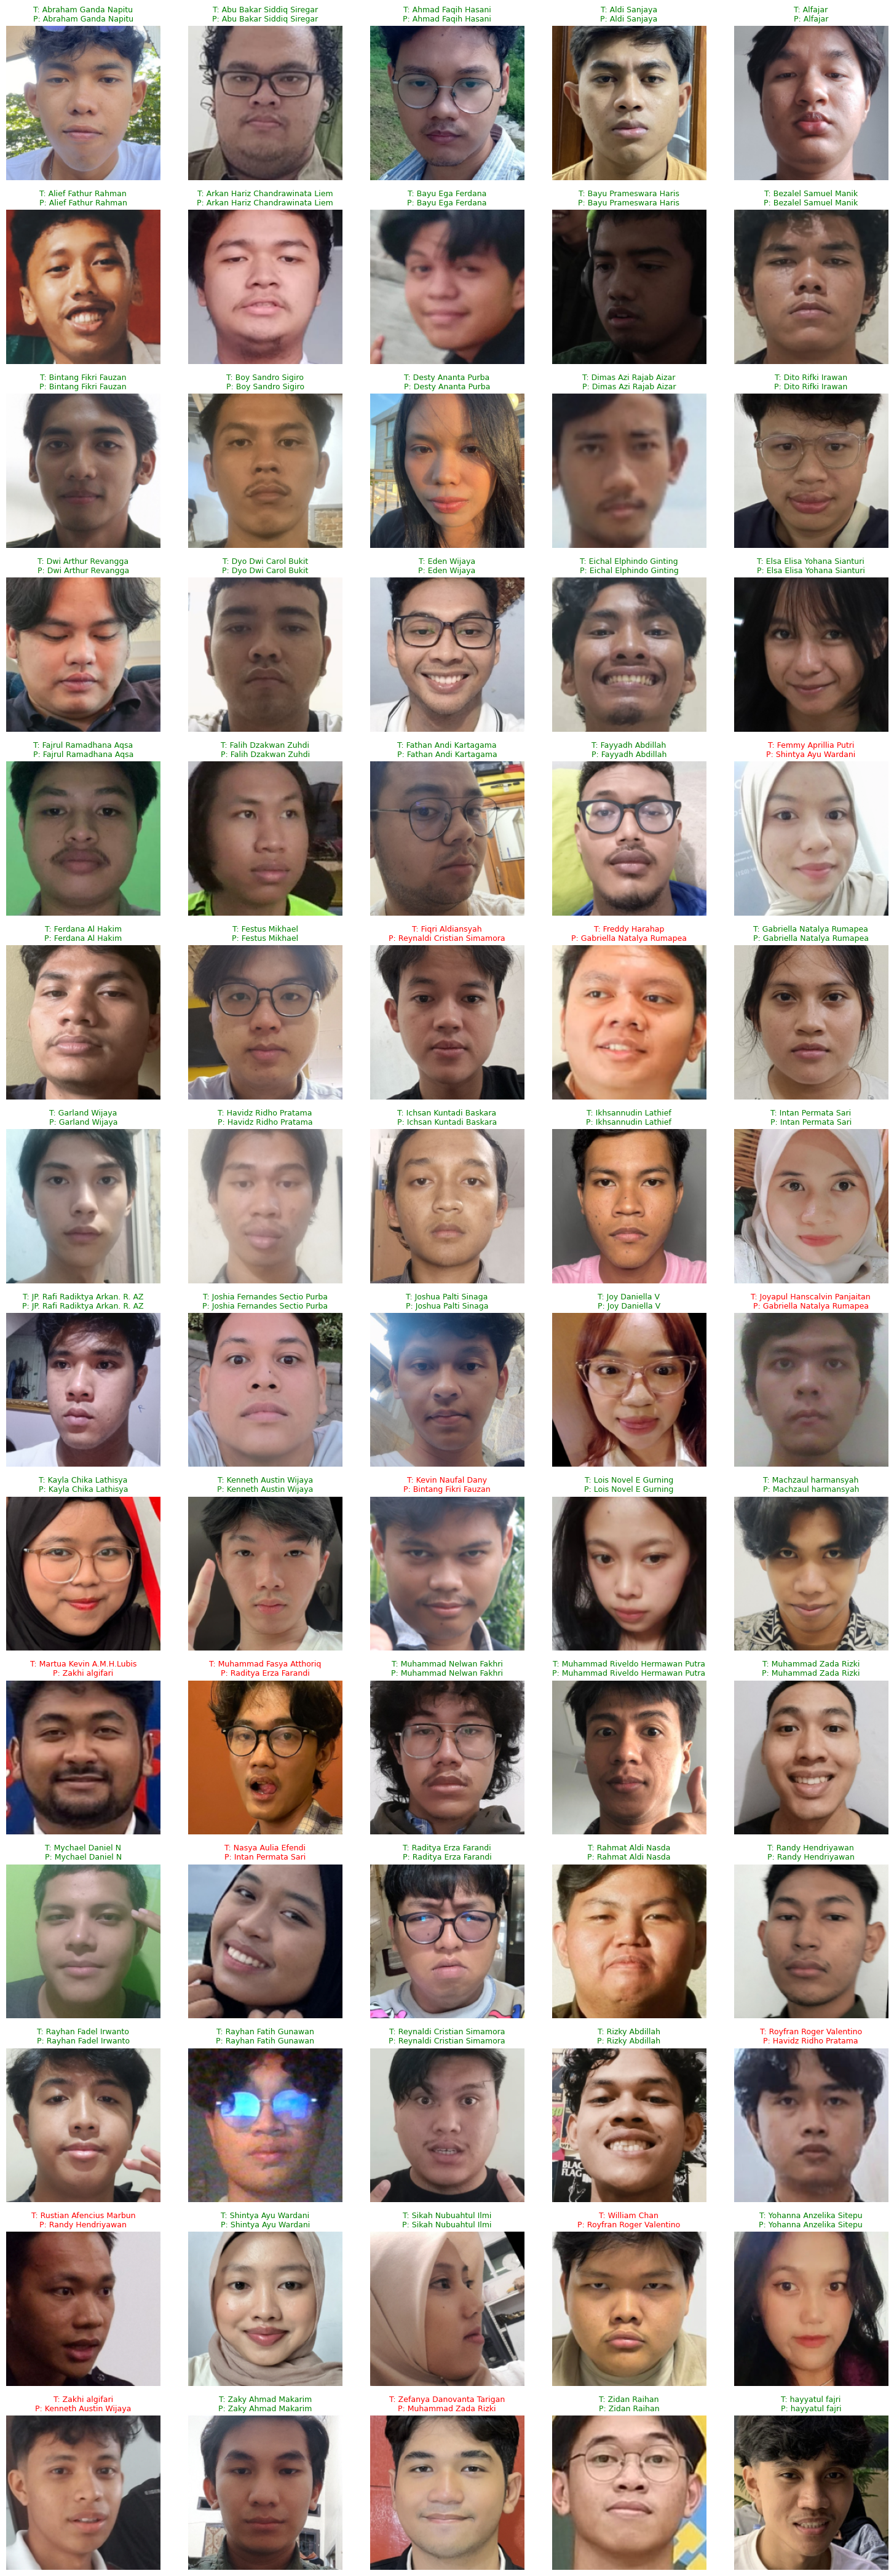

Displayed 70 images.


In [11]:
# ======================================================
# Cell 10 – Prediction Visualization
# ======================================================
import matplotlib.pyplot as plt

val_dataset = val_loader.dataset
idx_to_class = {v: k for k, v in label_map.items()}

IMAGENET_MEAN_T = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
IMAGENET_STD_T  = torch.tensor(IMAGENET_STD).view(3, 1, 1)

def denormalize(img_t: torch.Tensor) -> np.ndarray:
    img = img_t.cpu() * IMAGENET_STD_T + IMAGENET_MEAN_T
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img

# --- Grid settings ---
ROWS = 14
COLS = 5
MAX_SHOW = 70

model.eval()
images_shown = 0

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Preview Predictions"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits, _ = model(imgs, labels=None)
        preds = logits.argmax(1)

        for i in range(len(imgs)):
            if images_shown == 0:
                fig, axes = plt.subplots(
                    ROWS, COLS, figsize=(COLS * 3, ROWS * 3)
                )

            r = images_shown // COLS
            c = images_shown % COLS
            ax = axes[r, c]

            img_np = denormalize(imgs[i])
            true_idx = labels[i].item()
            pred_idx = preds[i].item()

            true_name = idx_to_class[true_idx]
            pred_name = idx_to_class[pred_idx]
            correct = (true_idx == pred_idx)

            ax.imshow(img_np)
            ax.set_title(
                f"T: {true_name}\nP: {pred_name}",
                fontsize=9,
                color=("green" if correct else "red"),
            )
            ax.axis("off")

            for spine in ax.spines.values():
                spine.set_edgecolor("green" if correct else "red")
                spine.set_linewidth(3)

            images_shown += 1
            if images_shown >= MAX_SHOW:
                break

        if images_shown >= MAX_SHOW:
            break

plt.tight_layout()
plt.show()
print(f"Displayed {images_shown} images.")
